## SHAP plots in UnitRefine paper


This notebook reproduces SHAP-based analyses used in the UnitRefine paper for **SUA vs non-SUA** classification.

It demonstrates how to:
1. Download an **example metrics dataset** from the Hugging Face Hub.
2. Train a simple binary classifier across **10 random seeds** (to quantify stability).
3. Compute SHAP values for each seed and plot **mean ± std SHAP importance** across seeds.
4. Select the best seed and generate SHAP summary / bar / decision plots.
5. Confusion matrix also for the  **best-performing seed** 

**Expected runtime:** training across 10 seeds can take a few minutes to 30 minuts depending on the dataset.

In [138]:
# Core imports
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from skops.io import load
from huggingface_hub import hf_hub_download, list_repo_files

import spikeinterface.curation as sc
from spikeinterface.curation.train_manual_curation import train_model

from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, confusion_matrix


In [139]:
def download_species_dataset(repo_id: str, species: str):
    species = species.lower()
    
    if species not in repo_id.lower():
        raise ValueError(
            f"Repository does not match requested species '{species}'."
        )

    files = list_repo_files(repo_id)
    target_file = f"{species}_dataset.csv"

    if target_file not in files:
        raise FileNotFoundError(
            f"{target_file} not found.\nAvailable files:\n{files}"
        )

    return hf_hub_download(repo_id=repo_id, filename=target_file)

def read_csv_clean(path: str) -> pd.DataFrame:
    """Read a CSV and drop common index columns created by pandas."""
    df = pd.read_csv(path)
    return df.drop(columns=["Unnamed: 0"])


## Define your variables 

| hugging_face_model             |species | 
|------------------------------|----------------------------|
|'AnoushkaJain3/UnitRefine-mice-sua-classifier'         | 'mice           | 
| 'AnoushkaJain3/UnitRefine-mole-rat-sua-classifier'            | 'mole-rat'            | 
|'AnoushkaJain3/UnitRefine-monkey-sua-classifier'                | 'monkey'          | 
| 'AnoushkaJain3/UnitRefine-human-sua-classifier'   | 'human'        | 


Edit the values below if you want to change:
- which Hugging Face repo is used 
- where outputs are written

By default, all outputs are saved to a local folder called `outputs/` next to this notebook (cross-platform).

In [ ]:
# Where to write outputs (cross-platform; avoids Windows-only paths)
output_base = Path("outputs")
output_base.mkdir(parents=True, exist_ok=True)

# Hugging Face repo containing the example dataset + trained pipeline
hugging_face_model = 'AnoushkaJain3/UnitRefine-mice-sua-classifier'
species='mice'   # used to auto-locate '<species>_dataset.csv'

### Load dataset
We automatically download `<species>_dataset.csv` file.


In [141]:
# Download metrics CSV (cached by HF) and show local path
metrics_path = download_species_dataset(hugging_face_model, species)
print("metrics_path =", metrics_path)

metrics_path = C:\Users\jain\.cache\huggingface\hub\models--AnoushkaJain3--UnitRefine-mice-sua-classifier\snapshots\a3a5ca19c8e7b02d3aca31ed494d3d78a489b7dc\mice_dataset.csv


### Load feature columns

We load a pretrained UnitRefine pipeline to recover the exact feature names (`feature_names_in_`), ensuring the CSV is parsed consistently.

In [142]:
import spikeinterface.curation as sc

model, model_info = sc.load_model(
    repo_id = hugging_face_model,
    trusted = ['numpy.dtype']
)

feature_columns = model.feature_names_in_
print("Quality Metrics being used: ", feature_columns)
print(f"\nTotal features : {len(feature_columns)}")

Quality Metrics being used:  ['num_spikes' 'firing_rate' 'presence_ratio' 'snr' 'isi_violations_ratio'
 'isi_violations_count' 'rp_contamination' 'rp_violations'
 'sliding_rp_violation' 'amplitude_cutoff' 'amplitude_median'
 'amplitude_cv_median' 'amplitude_cv_range' 'sync_spike_2' 'sync_spike_4'
 'sync_spike_8' 'firing_range' 'drift_ptp' 'drift_std' 'drift_mad'
 'isolation_distance' 'l_ratio' 'd_prime' 'silhouette' 'nn_hit_rate'
 'nn_miss_rate' 'peak_to_valley' 'peak_trough_ratio' 'half_width'
 'repolarization_slope' 'recovery_slope' 'num_positive_peaks'
 'num_negative_peaks' 'velocity_above' 'velocity_below' 'exp_decay'
 'spread']

Total features : 37


### Load labels

`human_labels` is used as the ground-truth label column for training and evaluation.

In [143]:
df = pd.read_csv(metrics_path)
label_column = 'human_labels'
label = df[label_column].to_list()

print("Dataset shape:", df.shape)

Dataset shape: (10833, 40)


## 1) Train across 10 seeds and collect balanced accuracy

Each run writes a folder `outputs/cv_seed_<seed>/` containing:
- train/test split CSVs (`X_train_data.csv`, `X_test_data.csv`, etc.)
- predictions (`y_pred_0.csv`)
- the trained pipeline (`best_model.skops`)



 Running fold 1/10 with seed 0...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 1: Balanced Accuracy = 0.912

 Running fold 2/10 with seed 1...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 2: Balanced Accuracy = 0.905

 Running fold 3/10 with seed 2...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 3: Balanced Accuracy = 0.906

 Running fold 4/10 with seed 3...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 4: Balanced Accuracy = 0.912

 Running fold 5/10 with seed 4...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 5: Balanced Accuracy = 0.912

 Running fold 6/10 with seed 5...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 6: Balanced Accuracy = 0.911

 Running fold 7/10 with seed 6...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 7: Balanced Accuracy = 0.905

 Running fold 8/10 with seed 7...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 8: Balanced Accuracy = 0.911

 Running fold 9/10 with seed 8...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 9: Balanced Accuracy = 0.899

 Running fold 10/10 with seed 9...
Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

Fold 10: Balanced Accuracy = 0.915


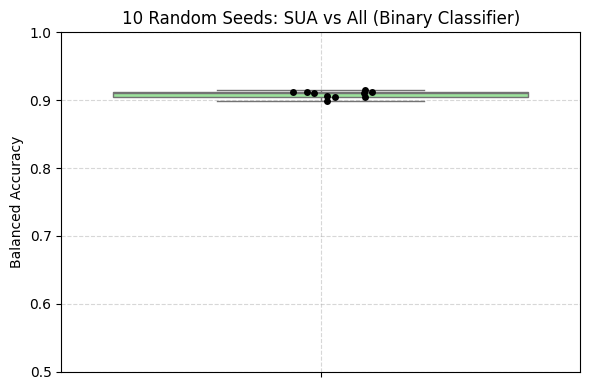

In [144]:

all_accuracies = []

for seed in range(10):
    print(f"\n Running fold {seed + 1}/10 with seed {seed}...")

    output_folder = os.path.join(output_base, f"cv_seed_{seed}")

    trainer = train_model(
        mode="csv",
        labels=[label],
        metrics_paths=[metrics_path],
        folder=output_folder,
        metric_names=feature_columns,
        imputation_strategies=["median"],
        scaling_techniques=["standard_scaler"],
        classifiers=None,  # Random Forest
        test_size=0.2,
        seed=seed,
        overwrite=True
    )

    best_model = trainer.best_pipeline

    # Load test data and predictions
    y_test = read_csv_clean(os.path.join(output_folder, 'y_test_data.csv'))['0']
    y_pred = read_csv_clean(os.path.join(output_folder, 'y_pred_0.csv'))['predicted_labels']

    # Balanced accuracy
    acc = balanced_accuracy_score(y_test, y_pred)
    all_accuracies.append(acc)
    print(f"Fold {seed + 1}: Balanced Accuracy = {acc:.3f}")

# === Plot final results ===
plt.figure(figsize=(6, 4))
sns.boxplot(y=all_accuracies, color='lightgreen')
sns.stripplot(y=all_accuracies, color='black', jitter=0.1, size=5)
plt.title("10 Random Seeds: SUA vs All (Binary Classifier)")
plt.ylabel("Balanced Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 2) SHAP variance across seeds 

For each seed:
- load `best_model.skops`
- apply preprocessing (imputer + scaler)
- compute SHAP values on the RandomForest step
- aggregate `mean(|SHAP|)` per feature

We always use **class 1** (SUA) SHAP values to be consistent across different SHAP output formats.

In [145]:
n_seeds = 10

feature_importances = []
accuracies = []
best_seed = None
best_acc = 0
best_explainer = None
best_X = None
best_shap_values = None

for seed in range(n_seeds):
    output_folder = os.path.join(output_base, f"cv_seed_{seed}")
    print(f"\n Processing seed {seed}...")

    # Load data
    X_test = read_csv_clean(os.path.join(output_folder, 'X_test_data.csv'))
    y_test = read_csv_clean(os.path.join(output_folder, 'y_test_data.csv'))['0']
    y_pred = read_csv_clean(os.path.join(output_folder, 'y_pred_0.csv'))['predicted_labels']

    # Load trained pipeline using skops
    model_path = os.path.join(output_folder, 'best_model.skops')
    model = load(model_path, trusted= ['numpy.dtype'])
    
    # Apply preprocessing
    X_input = X_test[feature_columns]
    X_input = model.named_steps['imputer'].transform(X_input)
    X_input = model.named_steps['scaler'].transform(X_input)

    # Compute SHAP for the RF classifier
    rf = model.named_steps['classifier']
    explainer = shap.TreeExplainer(rf)
    shap_vals = explainer.shap_values(X_input)

    # ---- NEW robust handling block ----
    if isinstance(shap_vals, list):
        # Classic multiclass format: list of arrays per class
        shap_vals_class_1 = shap_vals[1]  # Class 1 = SUA
    elif shap_vals.ndim == 3 and shap_vals.shape[2] == 2:
        # SHAP gave a 3D array: (n_samples, n_features, n_classes)
        shap_vals_class_1 = shap_vals[:, :, 1]  # select class 1 = SUA
    else:
        # Already correct shape
        shap_vals_class_1 = shap_vals

    # Final check
    assert shap_vals_class_1.shape[1] == len(feature_columns), \
        f"SHAP mismatch: got {shap_vals_class_1.shape[1]} features, expected {len(feature_columns)}"

    # Aggregate SHAP values
    mean_shap = np.abs(shap_vals_class_1).mean(axis=0)  # shape: (n_features,)
    feature_importances.append(pd.Series(mean_shap, index=feature_columns))

    # Accuracy
    acc = balanced_accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f" Seed {seed}: Balanced Accuracy = {acc:.3f}")

    if acc > best_acc:
        best_seed = seed
        best_acc = acc
        best_explainer = explainer
        best_X = (X_input, feature_columns)
        best_shap_values = shap_vals

importance_df = pd.concat(feature_importances, axis=1)
importance_df.columns = [f"Seed_{i}" for i in range(n_seeds)]

mean_importance = importance_df.mean(axis=1)
std_importance = importance_df.std(axis=1)

sorted_features = mean_importance.sort_values(ascending=False)


 Processing seed 0...
 Seed 0: Balanced Accuracy = 0.912

 Processing seed 1...
 Seed 1: Balanced Accuracy = 0.905

 Processing seed 2...
 Seed 2: Balanced Accuracy = 0.906

 Processing seed 3...
 Seed 3: Balanced Accuracy = 0.912

 Processing seed 4...
 Seed 4: Balanced Accuracy = 0.912

 Processing seed 5...
 Seed 5: Balanced Accuracy = 0.911

 Processing seed 6...
 Seed 6: Balanced Accuracy = 0.905

 Processing seed 7...
 Seed 7: Balanced Accuracy = 0.911

 Processing seed 8...
 Seed 8: Balanced Accuracy = 0.899

 Processing seed 9...
 Seed 9: Balanced Accuracy = 0.915


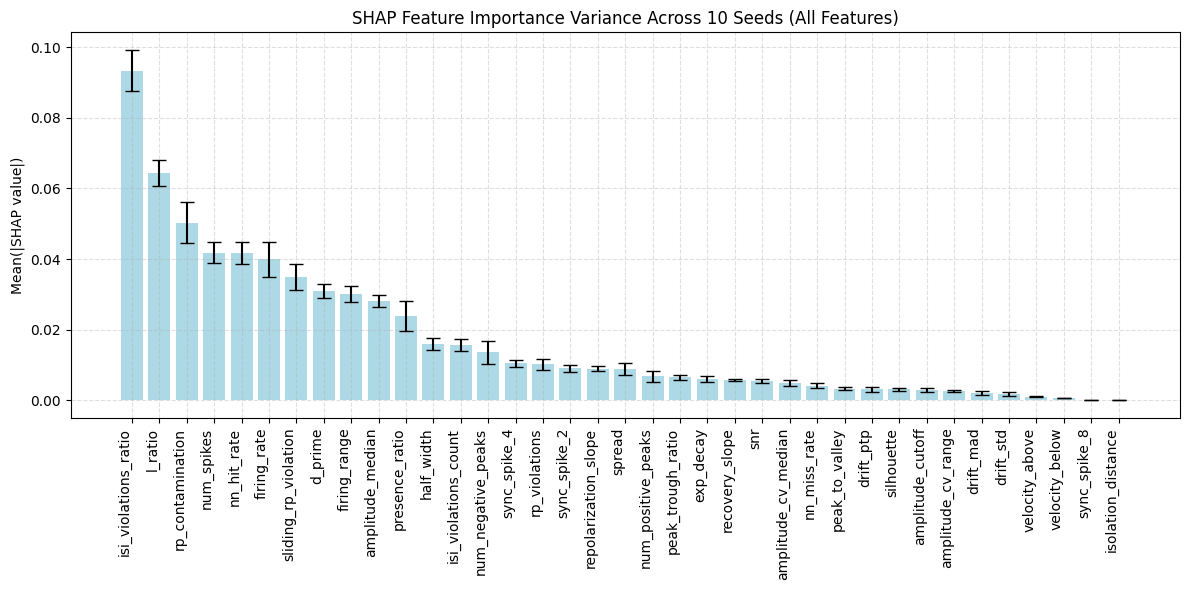

In [146]:
# Sort all features by mean SHAP value
sorted_features = mean_importance.sort_values(ascending=False).index

# Bar plot with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    x=range(len(sorted_features)),
    height=mean_importance[sorted_features],
    yerr=std_importance[sorted_features],
    capsize=5,
    color='lightblue'
)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90, ha='right')
plt.ylabel("Mean(|SHAP value|)")
plt.title("SHAP Feature Importance Variance Across 10 Seeds (All Features)")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [147]:
sorted_features

Index(['isi_violations_ratio', 'l_ratio', 'rp_contamination', 'num_spikes',
       'nn_hit_rate', 'firing_rate', 'sliding_rp_violation', 'd_prime',
       'firing_range', 'amplitude_median', 'presence_ratio', 'half_width',
       'isi_violations_count', 'num_negative_peaks', 'sync_spike_4',
       'rp_violations', 'sync_spike_2', 'repolarization_slope', 'spread',
       'num_positive_peaks', 'peak_trough_ratio', 'exp_decay',
       'recovery_slope', 'snr', 'amplitude_cv_median', 'nn_miss_rate',
       'peak_to_valley', 'drift_ptp', 'silhouette', 'amplitude_cutoff',
       'amplitude_cv_range', 'drift_mad', 'drift_std', 'velocity_above',
       'velocity_below', 'sync_spike_8', 'isolation_distance'],
      dtype='object')

In [148]:
import matplotlib.pyplot as plt

print(f"\n Best model: Seed {best_seed} with accuracy {best_acc:.3f}")
X_input_best, feature_names_best = best_X


 Best model: Seed 9 with accuracy 0.915


## 3) SHAP plots for the best seed

We generate:
- SHAP summary plot
- mean |SHAP| bar plot
- decision plot (subsampled to avoid overplotting)

In [149]:
best_seed_data = os.path.join(output_base, f"cv_seed_{best_seed}")

X_test = read_csv_clean(os.path.join(best_seed_data, 'X_test_data.csv'))
y_test = read_csv_clean(os.path.join(best_seed_data, 'y_test_data.csv'))['0']
y_pred = read_csv_clean(os.path.join(best_seed_data, 'y_pred_0.csv'))['predicted_labels']

# Load model using skops
model_path = os.path.join(best_seed_data, 'best_model.skops')
best_model_mice_model = load(model_path, trusted= ['numpy.dtype'])

# Common function to get SHAP values
def preprocess_and_get_shap_values(best_model, X_test, feature_columns):
    X_test_transformed = best_model.named_steps['imputer'].transform(X_test[feature_columns])
    X_test_final = best_model.named_steps['scaler'].transform(X_test_transformed)
    rf = best_model.named_steps['classifier']
    samples = X_test_final
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(samples)
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
        expected_value = explainer.expected_value[1]
    elif len(shap_values.shape) == 3:
        shap_values_class1 = shap_values[:, :, 1]
        expected_value = explainer.expected_value[1]
    else:
        shap_values_class1 = shap_values
        expected_value = explainer.expected_value
    return shap_values_class1, samples, expected_value

shap_values_mice, samples_mice, expected_value_mice = preprocess_and_get_shap_values(best_model_mice_model, X_test, feature_columns)

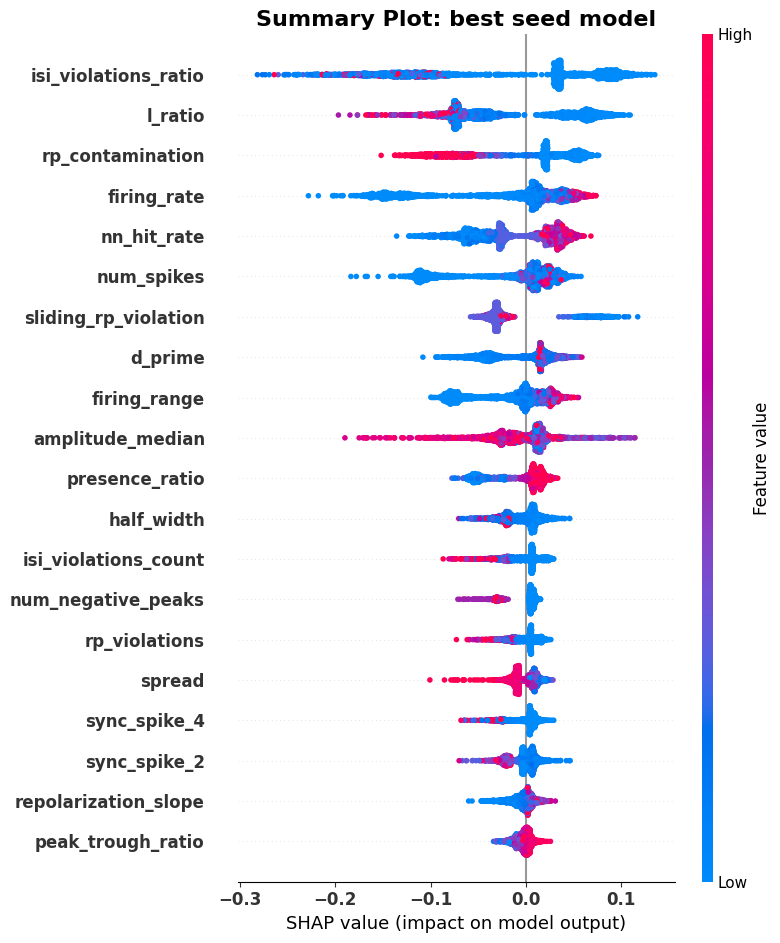

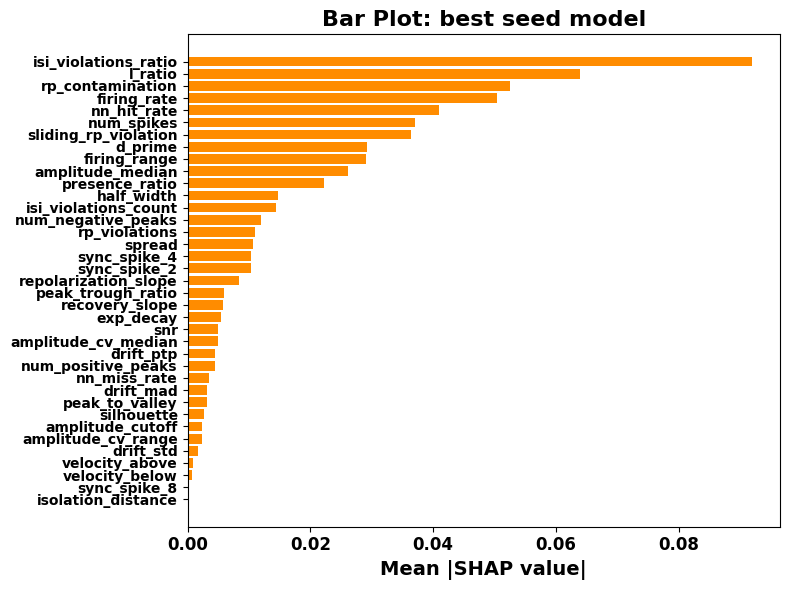

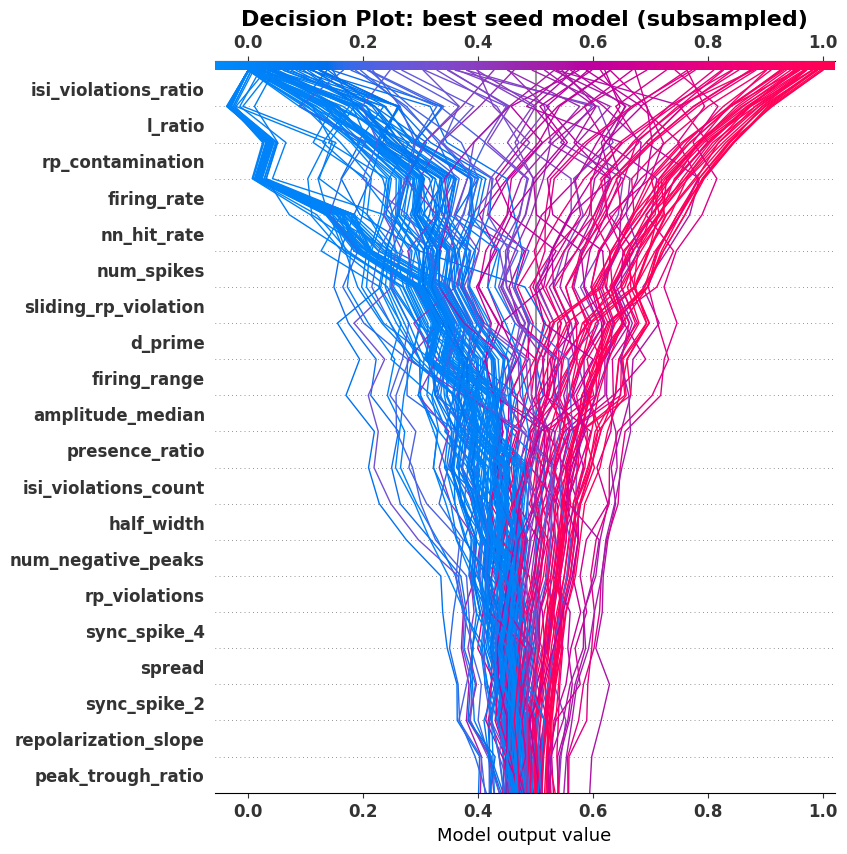

In [150]:

plt.figure(figsize=(10, 6))
plt.title('Summary Plot: best seed model', fontsize=16, fontweight='bold')
shap.summary_plot(shap_values_mice, samples_mice, feature_names=feature_columns, show=False)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

mean_abs_mice = np.abs(shap_values_mice).mean(axis=0)
sorted_idx_mice = np.argsort(-mean_abs_mice)  # sort descending

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_columns)[sorted_idx_mice], mean_abs_mice[sorted_idx_mice], color='darkorange')
plt.title("Bar Plot: best seed model", fontsize=16, fontweight='bold')
plt.xlabel("Mean |SHAP value|", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


n_samples = 200  

# reproducible subsampling
rng = np.random.default_rng(seed=42)
idx = rng.choice(len(shap_values_mice), size=n_samples, replace=False)

# subset SHAP + features
shap_subset = shap_values_mice[idx]
X_subset = df[feature_columns].iloc[idx]

plt.figure(figsize=(12, 6))
plt.title("Decision Plot: best seed model (subsampled)", fontsize=16, fontweight='bold')

shap.decision_plot(
    expected_value_mice,
    shap_subset,
    features=X_subset,
    feature_names=feature_columns,
    show=False
)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

## 4) Confusion matrix for the best seed

Balanced accuracy score: 0.92


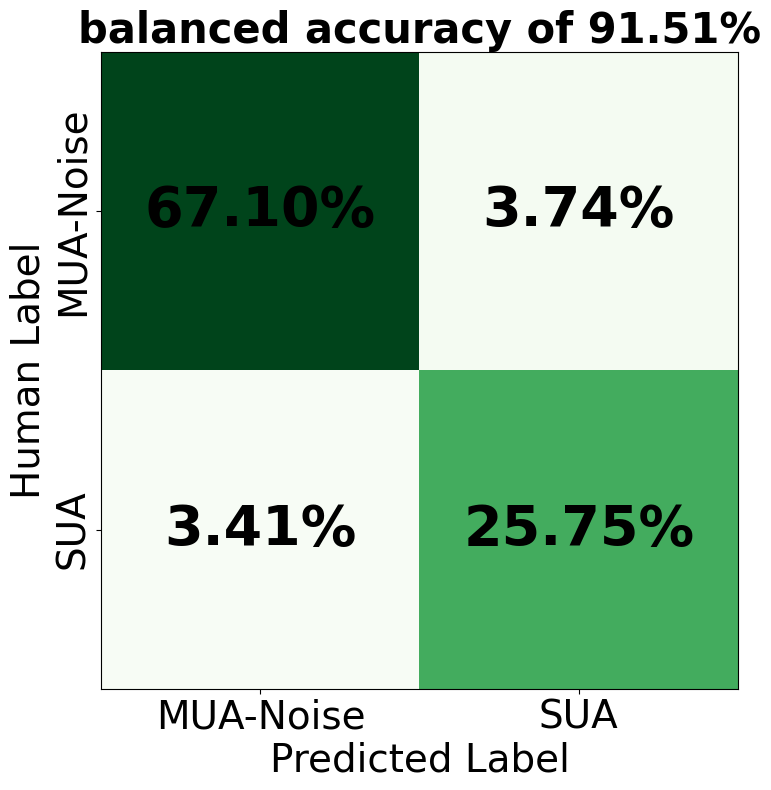

In [152]:
best_seed_data = os.path.join(output_base, f"cv_seed_{best_seed}")
X_test = read_csv_clean(os.path.join(best_seed_data, 'X_test_data.csv'))
y_test = read_csv_clean(os.path.join(best_seed_data, 'y_test_data.csv'))['0']
y_pred = read_csv_clean(os.path.join(best_seed_data, 'y_pred_0.csv'))['predicted_labels']

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy score: {balanced_acc:.2f}")

# round off the balanced accuracy score to 2 decimal places and convert to percentage
balanced_acc_percentage = round(balanced_acc * 100, 2)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

# Calculate percentages
total = sum(sum(conf_matrix))
conf_matrix_percentages = conf_matrix / total * 100

# Define a custom normalization function
def custom_norm(data):
    max_val = np.max(data)
    min_val = np.min(data)
    normalized = (data - min_val) / (max_val - min_val)  # Normalize data between 0 and 1
    return np.log(normalized * 9 + 1)  # Apply logarithmic transformation for contrast

# Normalize the confusion matrix data
normalized_matrix = custom_norm(conf_matrix_percentages)

# Increase figure size to provide more space
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentages, display_labels=[0, 1])

# Plot confusion matrix with percentages
plt.imshow(normalized_matrix, interpolation='nearest', cmap='Greens')

# Display percentages in each cell with bold text
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        # Define color based on whether it's the diagonal or off-diagonal element
        color = 'black' if i == j else 'black'  # Swap 'white' and 'black'
        plt.text(j, i, f"{conf_matrix_percentages[i, j]:.2f}%", ha='center', va='center', fontsize=40, color=color, weight='bold')

# Customizing x and y tick labels and increasing font size
plt.xticks(range(len(disp.display_labels)), ['MUA-Noise','SUA'], fontsize=28)
plt.yticks(range(len(disp.display_labels)), [ 'MUA-Noise','SUA',], rotation=90, fontsize=28, verticalalignment='center')  # Rotate y-axis ticks

# Add description below the confusion matrix
description = f"balanced accuracy of {balanced_acc_percentage}%"

plt.title(description, wrap=True, horizontalalignment='center', fontsize=30, weight='bold')

# Increase font size for title and labels
plt.xlabel('Predicted Label', fontsize=28)
plt.ylabel('Human Label', fontsize=28)

plt.tight_layout()

plt.show()